In [1]:
# %pip install opencv-python
# %pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
from imageProcessing import detect_board_and_warp, split_board_into_cells
from imgAlignment import align_board_sift_orb, extract_board_by_contour
from board import Game, Board, Tile, Color, Shape, Move
from tileDetection import is_tile_present

from DNN_shape_classifier import get_shape_model
import torch
import torchvision.transforms as transforms
from PIL import Image

from sklearn.cluster import KMeans
import cv2
import numpy as np

E5: circlered
F5: cloverred
G5: diamondred
Score: 3
['B8', 'B6', 'C7', 'C5', 'D6', 'D4', 'E5', 'E3', 'F4', 'F2', 'G3', 'G1']


In [2]:
def warp_template(template_img): 
    """
    Warps the template image to a standard size and saves it.
    Args:
        template_img (str): Path to the template image.
    Returns:
        warped_template (numpy.ndarray): Warped template image.
    """
    # warp template_img and show result
    # warped_template = cv2.imread(template_img[img_num-1])
    warped_template = cv2.imread(template_img)
    _, debug_lines, warped_template = detect_board_and_warp(warped_template, output_size=(800, 800))
    # plt.imshow(cv2.cvtColor(warped_template, cv2.COLOR_BGR2RGB))
    
    return warped_template

In [3]:
def align_board(wrp_tmp_path, query_img, output_size=(800, 800), show_details=False , use_sift=True, homography_threshold=0.85):
    """
    Aligns the query image to the template image using SIFT or ORB feature matching.
    Args:
        wrp_tmp_path (str): Path to the warped template image.
        query_img (str): Path to the query image.
        output_size (tuple): Desired output size for the aligned image.
        show_details (bool): Whether to show details of the alignment process.
        use_sift (bool): Whether to use SIFT for feature matching.
        homography_threshold (float): Threshold for homography filtering.
    Returns:
        aligned_img (numpy.ndarray): Aligned image.
    """
    try:
        # Attempt to extract the board using contours
        aligned_img = extract_board_by_contour(query_img, output_size, debug=True)
    except Exception as e:
        print(f"Contour extraction failed: {e}")
        tpl, qry, aligned_img, image_matches = align_board_sift_orb(wrp_tmp_path, query_img, output_size=(800,800), show_details=show_details , use_sift=use_sift, homography_threshold=homography_threshold)

    # Read template and query images
    template_img_array = wrp_tmp_path  # Read the template image

    query_img_array = cv2.imread(query_img)  # Read the query image
    if query_img_array is None:
        raise FileNotFoundError(f"Query image not found at path: {query_img}")

    for i, img in enumerate([template_img_array, query_img_array, aligned_img], 1):
        plt.subplot(1, 3, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(["Template", "Query", "Aligned"][i - 1])
    plt.show()
    
    return aligned_img

In [4]:
def split_board(warped, padding_cell=0, padding_detection=-0.15):
    """
    Splits the warped board into cells and detection grid.
    Args:
        warped (numpy.ndarray): Warped image of the board.
        padding_cell (int): Padding for cell splitting.
        padding_detection (float): Padding for detection grid splitting.
    Returns:
        detection_grid (dict): Dictionary of detection grid cells.
        cells_grid (dict): Dictionary of cell images.
    """
    detection_grid = split_board_into_cells(warped, 16, padding=padding_detection)
    cells_grid = split_board_into_cells(warped, 16, padding=padding_cell)
    
    return detection_grid, cells_grid



In [5]:

def tile_detection(cells_grid, detection_grid, tile_vs_back_threshol=60, min_foreground_ratio=0.28):
    """
    Detects tiles in the cells and checks if they are present.
    Args:
        cells_grid (dict): Dictionary of cell images.
        detection_grid (dict): Dictionary of detection grid cells.
        tile_vs_back_threshol (int): Threshold for tile vs background detection.
        min_foreground_ratio (float): Minimum ratio of foreground to background for tile detection.
    Returns:
        tiles (list): List of dictionaries containing tile information.
        tiles_present (list): List of dictionaries containing present tile information.
    """ 
    tiles = []
    tiles_present = []

    for label, cell_img in cells_grid.items():
        # Check if a tile is present in the current cell
        is_present = is_tile_present(cells_grid.get(label), threshold=tile_vs_back_threshol, min_foreground_ratio=min_foreground_ratio)
        
        # Add the tile information to the tiles list
        tiles.append({'label': label, 'isPresent': is_present, 'img': cell_img})
        
        # If a tile is present, add it to the tiles_present list
        if is_present:
            tiles_present.append({'label': label, 'isPresent': is_present, 'img': cell_img, 'detection_img': detection_grid.get(label)})
            
    return tiles, tiles_present
    

In [6]:
# plt.figure(figsize=(20, 12))
# for i, tile in enumerate(tiles, 1):
#     label = tile['label']
#     tile_present = tile['isPresent']
#     plt.subplot(16, 16, i)
#     plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
#     plt.title(f"{label}: {'Tile' if tile_present else 'No Tile'}")
#     plt.axis("off")
# plt.tight_layout()

In [7]:
# %pip install torch
# %pip install torchvision

def classify_tiles(tiles_present):
    """
    Classifies the tiles using a resnet model.
    Args:
        tiles_present (list): List of dictionaries containing present tile information.
    Returns:
        tiles_classified (list): List of dictionaries containing classified tile information.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classifier = get_shape_model(num_classes=10)
    classifier.load_state_dict(torch.load("resnet_shape.pt", map_location=device))
    classifier.to(device)
    classifier.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    shape_names = ["0", "7", "8", "circle", "clover", "diamond", "square", "star4", "star8"]

    tiles_classified = []

    for tile in tiles_present:
        if not tile['isPresent']:
            continue

        label = tile['label']
        patch_img = tile['img']

        if patch_img is None or not isinstance(patch_img, np.ndarray):
            print(f"[WARN] Invalid image at {label}")
            continue

        try:
            # Convert OpenCV image to PIL
            img_pil = Image.fromarray(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
        except Exception as e:
            print(f"[ERROR] Failed to convert image at {label}: {e}")
            continue

        # Apply transform and predict
        input_tensor = transform(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(input_tensor)
            pred_idx = output.argmax(dim=1).item()
            shape = shape_names[pred_idx]

        print(f"Tile at {label}: {shape}")
        tiles_classified.append({'label': label, 'shape': shape, 'img': patch_img})
    
    return tiles_classified
    

In [8]:
# plot images with preent tiles
# plt.figure(figsize=(20, 12))
# for i, tile in enumerate(tiles_classified, 1):
#     label = tile['label']
#     shape = tile['shape']
#     plt.subplot(16, 16, i)
#     plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
#     plt.title(f"{label}: {shape}")
#     plt.axis("off")
# plt.tight_layout()

# # save tiles to tiles_dataset
# import os

# # Create a folder to save the tiles if it doesn't exist
# output_folder = "tiles_patches"
# os.makedirs(output_folder, exist_ok=True)

# # Iterate through the tiles_present list
# for tile in tiles_present:
#     label = tile['label']
#     tile_present = tile['isPresent']
#     if tile_present:  # Only save images where a tile is detected
#         # gray scale patches
#         # cells_grid[label] = cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2GRAY)
#         output_path = os.path.join(output_folder, f"{label}-4.jpg")
#         cv2.imwrite(output_path, cells_grid[label])  # Save the cell image

In [9]:
def map_color_to_name(color_bgr):
    # Simplified color label matching
    color_bgr = np.array(color_bgr)
    colors = {
        "red":     np.array([60, 60, 200]),
        "blue":    np.array([200, 60, 60]),
        "green":   np.array([60, 200, 60]),
        "yellow":  np.array([0, 220, 220]),
        "orange":  np.array([0, 140, 255]),
        # "purple":  np.array([150, 60, 150]),
        # "black":   np.array([0, 0, 0]),
        "white":   np.array([255, 255, 255]),
    }

    min_dist = float('inf')
    best_match = "unknown"
    for name, ref in colors.items():
        dist = np.linalg.norm(color_bgr - ref)
        if dist < min_dist:
            min_dist = dist
            best_match = name
    return best_match


In [10]:
def extract_patch_color(image, row, col, grid_size=(6, 6), min_nonzero_pixels=30):
    h, w = image.shape[:2]
    patch_h, patch_w = h // grid_size[1], w // grid_size[0]

    x1 = col * patch_w
    y1 = row * patch_h
    patch = image[y1:y1 + patch_h, x1:x1 + patch_w]

    # Convert to HSV and apply mask to filter out background-like areas
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0, 50, 50), (180, 255, 255))  # adjust as needed

    # Extract only valid pixels
    pixels = patch[mask > 0].reshape(-1, 3)

    if len(pixels) < min_nonzero_pixels:
        return "empty"

    # KMeans to get dominant color
    kmeans = KMeans(n_clusters=1, n_init='auto').fit(pixels)
    color = kmeans.cluster_centers_[0].astype(int)

    return map_color_to_name(color)


In [11]:
def classify_tiles_full(tiles_present, tiles_classified):
    """
    Classifies the tiles using a pre-trained model and detects their colors.
    Args:
        tiles_present (list): List of dictionaries containing present tile information.
        tiles_classified (list): List of dictionaries containing classified tile information.
    Returns:
        tiles_full_classified (list): List of dictionaries containing fully classified tile information.
    """
    tiles_full_classified = []

    for tile in tiles_present:
        if not tile['isPresent']:
            continue

        img = tile['img']
        shape = next((t['shape'] for t in tiles_classified if t['label'] == tile['label']), None)
        if shape is None:
            print(f"[WARN] Shape not found for tile {tile['label']}")
            continue

        try:
            # Detect color using extract_patch_color assuming 1 tile = 1 patch
            color = extract_patch_color(img, row=0, col=0, grid_size=(1, 1))  # full image = 1 patch
        except Exception as e:
            print(f"[ERROR] Failed color detection for tile {tile['label']}: {e}")
            color = "unknown"

        print(f"{tile['label']}: {color}")
        tiles_full_classified.append({'label': tile['label'], 'shape': shape, 'color': color, 'img': img})
    
    return tiles_full_classified


In [12]:
# plot pathces with tiles with both shape and color
# plt.figure(figsize=(25, 12))
# for i, tile in enumerate(tiles_full_classified, 1):
#     label = tile['label']
#     shape = tile['shape']
#     color = tile['color']
#     plt.subplot(16, 16, i)
#     plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
#     plt.title(f"{label}: {shape}, {color}")
#     plt.axis("off")
# plt.tight_layout()

In [13]:
import re

train_01_list = [f"train/1_{i:02d}.jpg" for i in range(21)] 
input_img = 'evaluation/fake_test/1_02.jpg'
template_img = ["train/1_00.jpg", "train/2_00.jpg", "train/3_00.jpg", "train/4_00.jpg", "train/5_00.jpg"]  
fake_test_template = "evaluation/fake_test/1_00.jpg" 
query_img = input_img             
    
# for img in train_01_list:
#     match = re.search(r'/(?P<number>\d+)_', img) # THIS MIGHT HAVE TO BE REMOVED WHEN PROJECT FINISHED AND SENT FOR EVALUATION}
#     img_num = 0
#     if match:
#         img_num = match.group('number')
#         #set to int
#         img_num = int(img_num)

# aligned_img = align_board(warp_template(template_img[img_num - 1]), "train/1_01.jpg", output_size=(800, 800), show_details=False , use_sift=True, homography_threshold=0.85)
# plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.title("Aligned Image")

Processing image: train/1_00.jpg


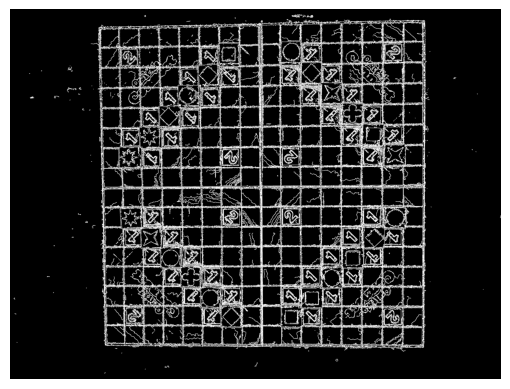

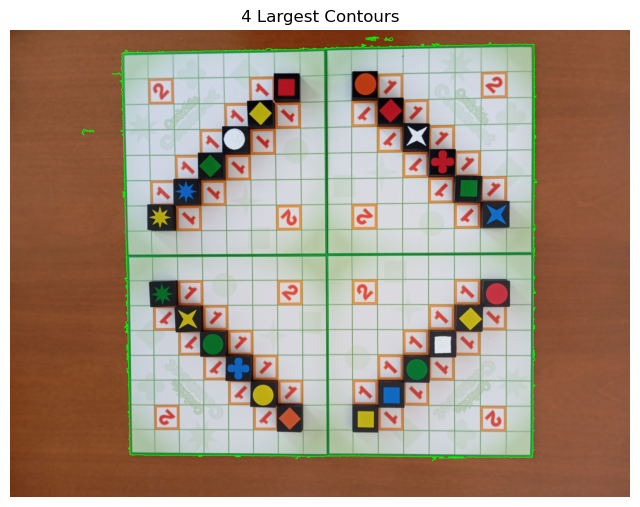

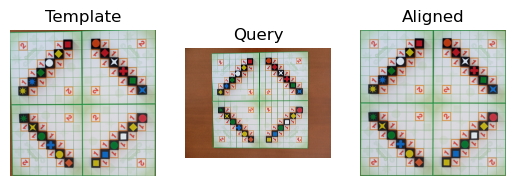

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B7: square
Tile at B10: circle
Tile at C6: circle
Tile at C11: diamond
Tile at D5: circle
Tile at D12: star4
Tile at E4: diamond
Tile at E13: clover
Tile at F3: star4
Tile at F14: square
Tile at G2: star4
Tile at G15: star4
Tile at J2: clover
Tile at J15: circle
Tile at K3: star4
Tile at K14: circle
Tile at L4: circle
Tile at L13: circle
Tile at M5: clover
Tile at M12: circle
Tile at N6: circle
Tile at N11: circle
Tile at O7: circle
Tile at O10: circle


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

B7: red
B10: red
C6: yellow
C11: red
D5: blue
D12: blue
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J15: red
K3: orange
K14: red
L4: green
L13: red
M5: blue
M12: green
N6: yellow
N11: blue
O7: red
O10: yellow
Move 0: B7: squarered
B10: circlered
C6: circleyellow
C11: diamondred
D5: circleblue
D12: star4blue
E4: diamondgreen
E13: cloverred
F3: star4blue
F14: squaregreen
G2: star4red
G15: star4blue
J2: clovergreen
J15: circlered
K3: star4orange
K14: circlered
L4: circlegreen
L13: circlered
M5: cloverblue
M12: circlegreen
N6: circleyellow
N11: circleblue
O7: circlered
O10: circleyellow
Score: 0
Processing image: train/1_01.jpg


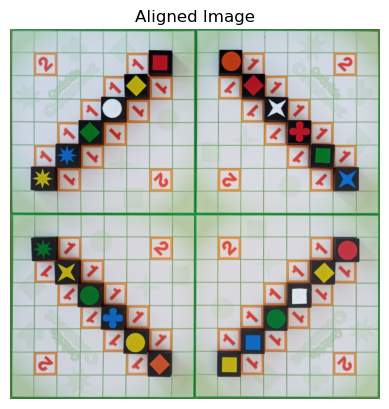

<Figure size 2000x1200 with 0 Axes>

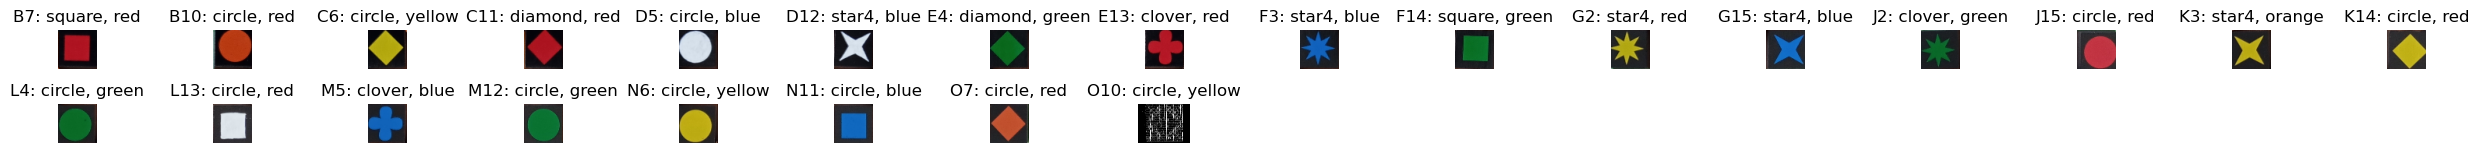

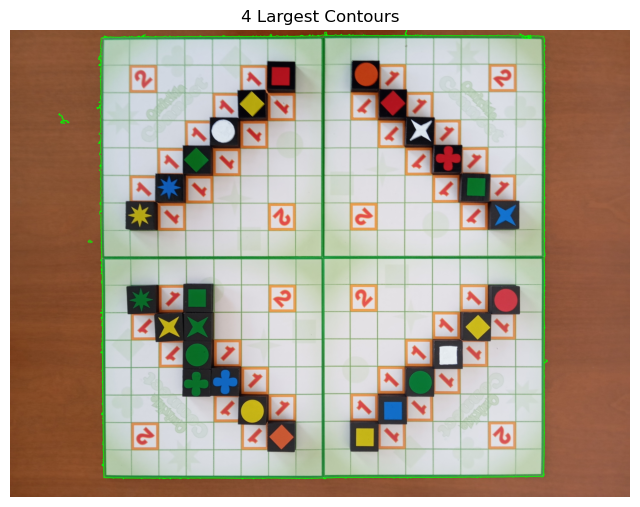

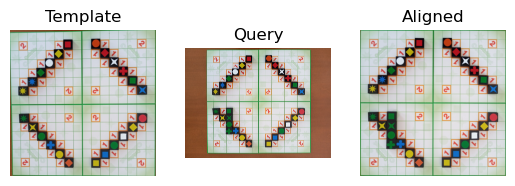

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B7: diamond
Tile at B10: circle
Tile at C6: diamond
Tile at C11: diamond
Tile at D5: circle
Tile at D12: star8
Tile at E4: diamond
Tile at E13: clover
Tile at F3: star4
Tile at F14: square
Tile at G2: star4
Tile at G15: circle
Tile at J2: clover
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L13: circle
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N6: circle
Tile at N11: circle
Tile at O7: circle
Tile at O10: circle


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

B7: red
B10: red
C6: yellow
C11: red
D5: blue
D12: red
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: yellow
K4: green
K14: yellow
L4: green
L13: red
M4: green
M5: blue
M12: green
N6: orange
N11: blue
O7: red
O10: yellow
Move 1: B7: diamondred
B10: circlered
C6: diamondyellow
C11: diamondred
D5: circleblue
D12: star8red
E4: diamondgreen
E13: cloverred
F3: star4blue
F14: squaregreen
G2: star4red
G15: circleblue
J2: clovergreen
J4: circlegreen
J15: circlered
K3: star4yellow
K4: star4green
K14: circleyellow
L4: circlegreen
L13: circlered
M4: clovergreen
M5: cloverblue
M12: circlegreen
N6: circleorange
N11: circleblue
O7: circlered
O10: circleyellow
Score: 4
Processing image: train/1_02.jpg


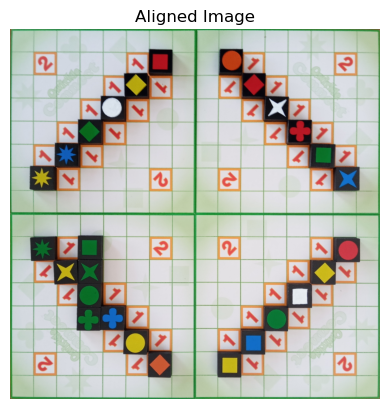

<Figure size 2000x1200 with 0 Axes>

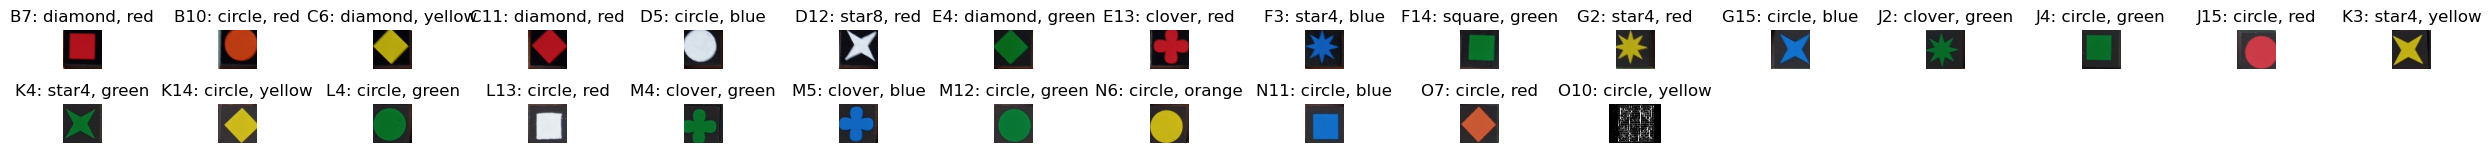

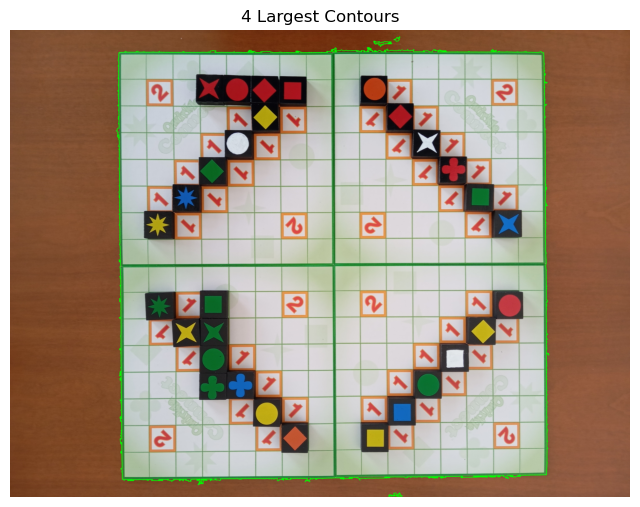

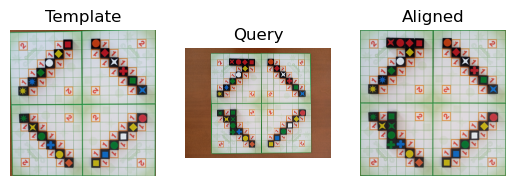

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B4: star4
Tile at B5: circle
Tile at B6: diamond
Tile at B7: square
Tile at B10: circle
Tile at C6: circle
Tile at C11: diamond
Tile at D5: circle
Tile at D12: star4
Tile at E4: diamond
Tile at E13: clover
Tile at F3: star4
Tile at F14: circle
Tile at G2: star4
Tile at G15: circle
Tile at J2: clover
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L13: circle
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N6: circle
Tile at N11: circle
Tile at O7: circle
Tile at O10: circle
B4: red
B5: red
B6: red
B7: red
B10: red
C6: orange
C11: red
D5: red
D12: red
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

K3: orange
K4: green
K14: red
L4: green
L13: red
M4: green
M5: blue
M12: green
N6: red
N11: blue
O7: red
O10: red
Move 2: B4: star4red
B5: circlered
B6: diamondred
B7: squarered
B10: circlered
C6: circleorange
C11: diamondred
D5: circlered
D12: star4red
E4: diamondgreen
E13: cloverred
F3: star4blue
F14: circlegreen
G2: star4red
G15: circleblue
J2: clovergreen
J4: circlegreen
J15: circlered
K3: star4orange
K4: star4green
K14: circlered
L4: circlegreen
L13: circlered
M4: clovergreen
M5: cloverblue
M12: circlegreen
N6: circlered
N11: circleblue
O7: circlered
O10: circlered
Score: 8
Processing image: train/1_03.jpg


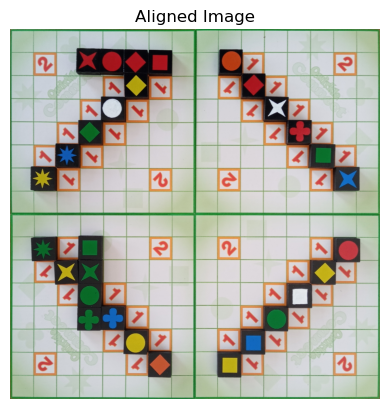

<Figure size 2000x1200 with 0 Axes>

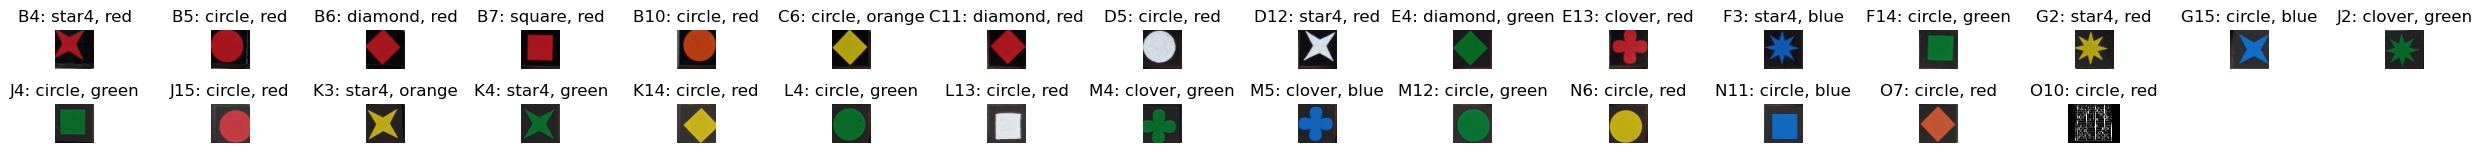

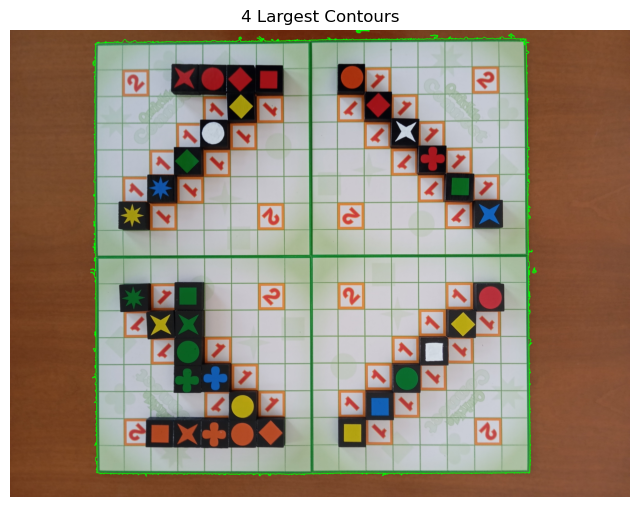

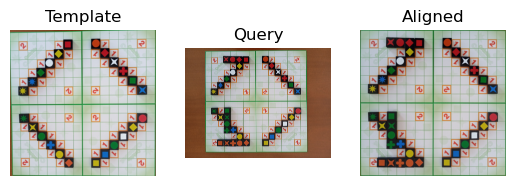

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B4: star4
Tile at B5: circle
Tile at B6: diamond
Tile at B7: square
Tile at B10: circle
Tile at C6: diamond
Tile at C11: clover
Tile at D5: 0
Tile at D12: star4
Tile at E4: diamond
Tile at E13: clover
Tile at F3: star4
Tile at F14: square
Tile at G2: star4
Tile at G15: star4
Tile at J2: star4
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L13: circle
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N6: circle
Tile at N11: circle
Tile at O3: circle
Tile at O4: star4
Tile at O5: diamond
Tile at O6: circle
Tile at O7: diamond
Tile at O10: circle
B4: red
B5: red
B6: red
B7: red
B10: red
C6: orange
C11: red
D12: blue
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: orange
K4: green
K14: orange
L4: green
L13: red
M4: green
M5: blue
M12: green
N6: yellow
N11: blue
O3: red
O4: red
O5: red
O6: red
O7: red
O10: orange


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

Move 3: B4: star4red
B5: circlered
B6: diamondred
B7: squarered
B10: circlered
C6: diamondorange
C11: cloverred
D12: star4blue
E4: diamondgreen
E13: cloverred
F3: star4blue
F14: squaregreen
G2: star4red
G15: star4blue
J2: star4green
J4: circlegreen
J15: circlered
K3: star4orange
K4: star4green
K14: circleorange
L4: circlegreen
L13: circlered
M4: clovergreen
M5: cloverblue
M12: circlegreen
N6: circleyellow
N11: circleblue
O3: circlered
O4: star4red
O5: diamondred
O6: circlered
O7: diamondred
O10: circleorange
Score: 13
Processing image: train/1_04.jpg


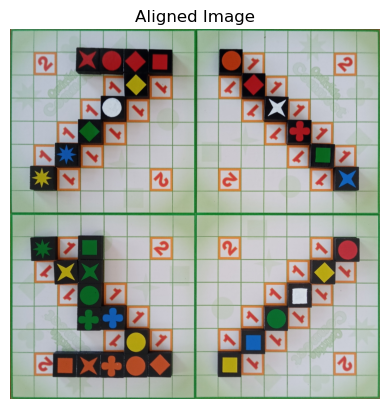

<Figure size 2000x1200 with 0 Axes>

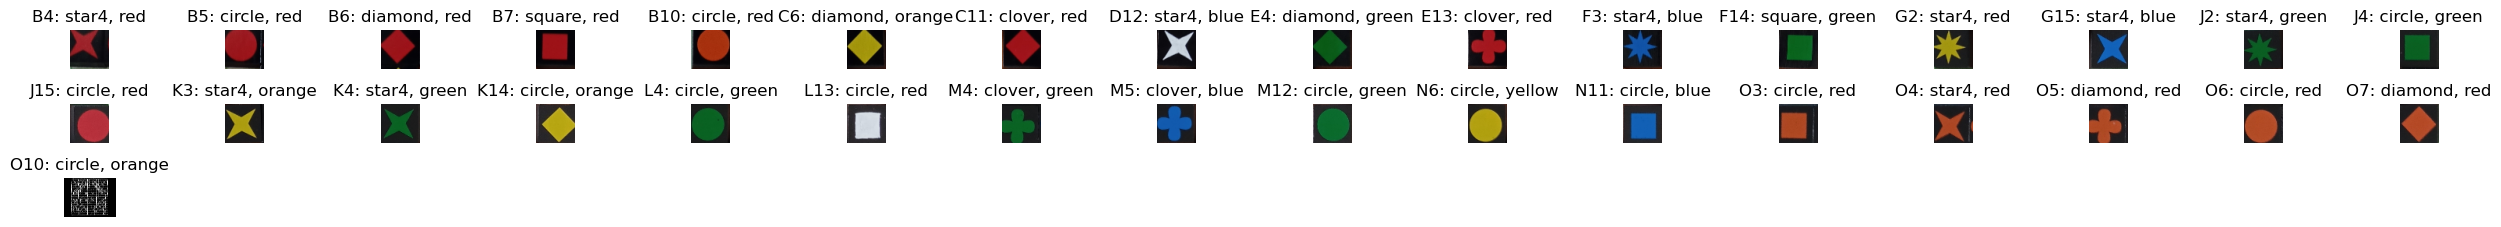

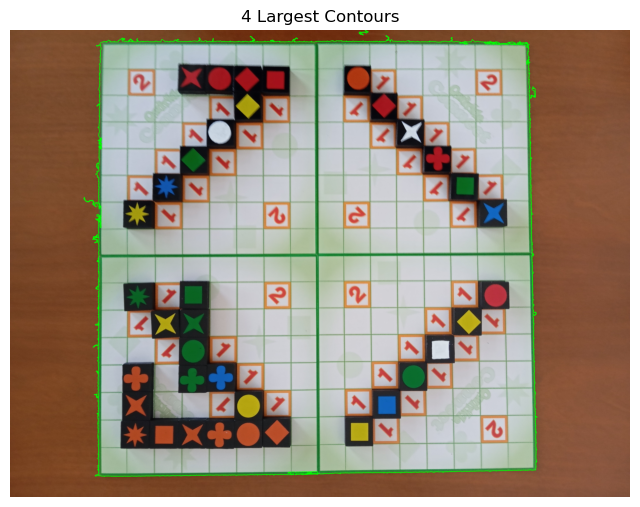

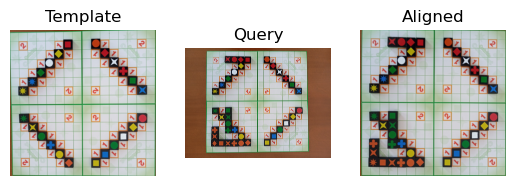

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B4: clover
Tile at B5: circle
Tile at B6: clover
Tile at B7: clover
Tile at B10: circle
Tile at C6: diamond
Tile at C11: diamond
Tile at D5: 0
Tile at D12: star8
Tile at E4: clover
Tile at E13: clover
Tile at F3: clover
Tile at F14: clover
Tile at G2: star8
Tile at G15: star4
Tile at J2: clover
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L13: circle
Tile at M2: clover
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N2: star4
Tile at N6: circle
Tile at N11: circle
Tile at O2: star8
Tile at O3: square
Tile at O4: star4
Tile at O5: clover
Tile at O6: circle
Tile at O7: diamond
Tile at O10: square
B4: red
B5: red
B6: red
B7: red
B10: red
C6: red
C11: red
D12: red
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: red
K4: green
K14: red
L4: green
L13: red
M2: red
M4: green
M5: blue
M12: green
N2: red
N6: yellow
N11: blue
O2: red
O3: red
O4: red
O5: r

c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

Move 4: B4: cloverred
B5: circlered
B6: cloverred
B7: cloverred
B10: circlered
C6: diamondred
C11: diamondred
D12: star8red
E4: clovergreen
E13: cloverred
F3: cloverblue
F14: clovergreen
G2: star8red
G15: star4blue
J2: clovergreen
J4: circlegreen
J15: circlered
K3: star4red
K4: star4green
K14: circlered
L4: circlegreen
L13: circlered
M2: cloverred
M4: clovergreen
M5: cloverblue
M12: circlegreen
N2: star4red
N6: circleyellow
N11: circleblue
O2: star8red
O3: squarered
O4: star4red
O5: cloverred
O6: circlered
O7: diamondred
O10: squareyellow
Score: 23
Processing image: train/1_05.jpg


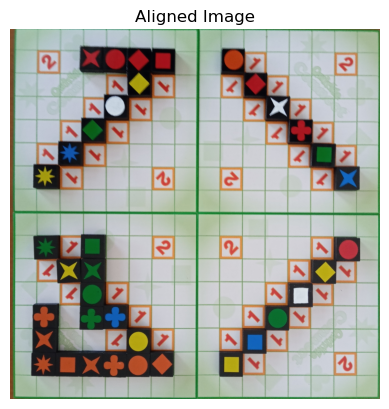

<Figure size 2000x1200 with 0 Axes>

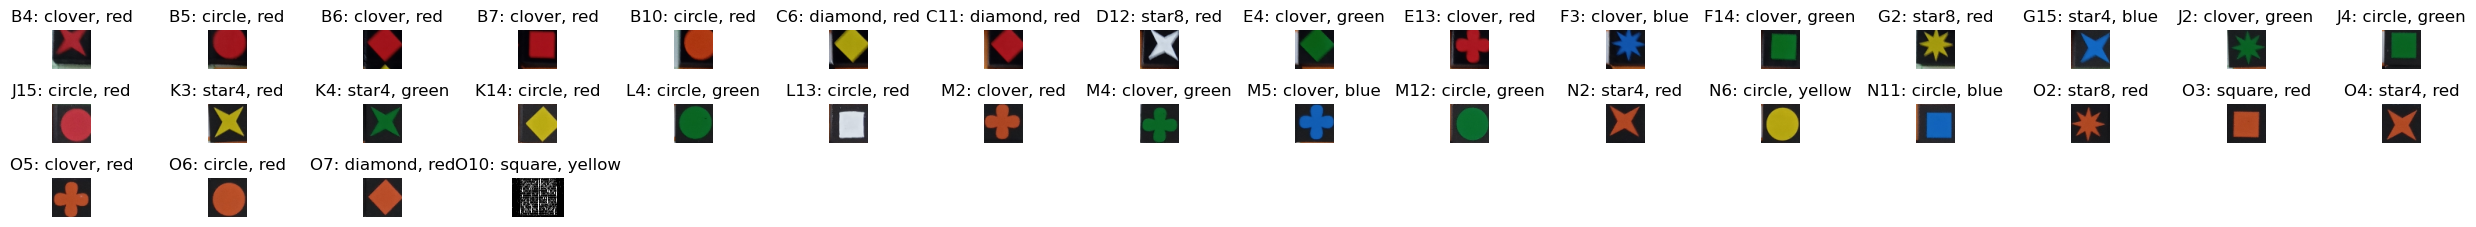

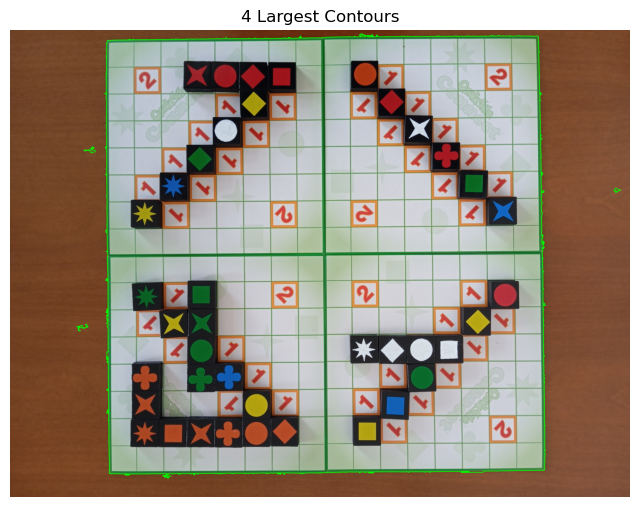

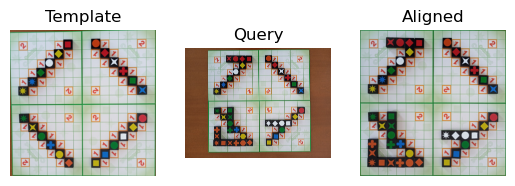

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B4: star4
Tile at B5: circle
Tile at B6: diamond
Tile at B7: clover
Tile at B10: circle
Tile at C6: diamond
Tile at C11: diamond
Tile at D5: 0
Tile at D12: star8
Tile at E4: diamond
Tile at E13: clover
Tile at F3: star4
Tile at F14: diamond
Tile at G2: star8
Tile at G15: star4
Tile at J2: star4
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L10: star8
Tile at L11: clover
Tile at L12: circle
Tile at L13: circle
Tile at M2: clover
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N2: star4
Tile at N6: circle
Tile at N11: circle
Tile at O2: star4
Tile at O3: circle
Tile at O4: star4
Tile at O5: diamond
Tile at O6: circle
Tile at O7: diamond
Tile at O10: square
B4: red
B5: red
B6: red
B7: red
B10: red


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

C6: yellow
C11: red
D12: blue
E4: green
E13: red
F3: blue
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: yellow
K4: green
K14: yellow
L4: green
L10: blue
L11: blue
L12: blue
L13: blue
M2: red
M4: green
M5: blue
M12: green
N2: red
N6: yellow
N11: blue
O2: red
O3: red
O4: red
O5: red
O6: red
O7: red
O10: yellow
Move 5: B4: star4red
B5: circlered
B6: diamondred
B7: cloverred
B10: circlered
C6: diamondyellow
C11: diamondred
D12: star8blue
E4: diamondgreen
E13: cloverred
F3: star4blue
F14: diamondgreen
G2: star8red
G15: star4blue
J2: star4green
J4: circlegreen
J15: circlered
K3: star4yellow
K4: star4green
K14: circleyellow
L4: circlegreen
L10: star8blue
L11: cloverblue
L12: circleblue
L13: circleblue
M2: cloverred
M4: clovergreen
M5: cloverblue
M12: circlegreen
N2: star4red
N6: circleyellow
N11: circleblue
O2: star4red
O3: circlered
O4: star4red
O5: diamondred
O6: circlered
O7: diamondred
O10: squareyellow
Score: 27
Processing image: train/1_06.jpg


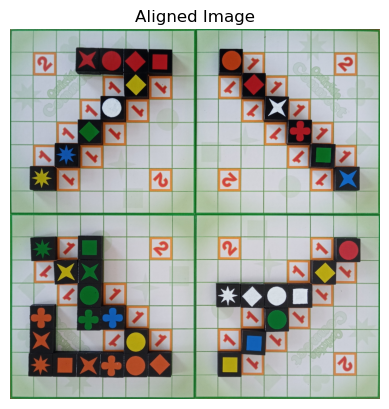

<Figure size 2000x1200 with 0 Axes>

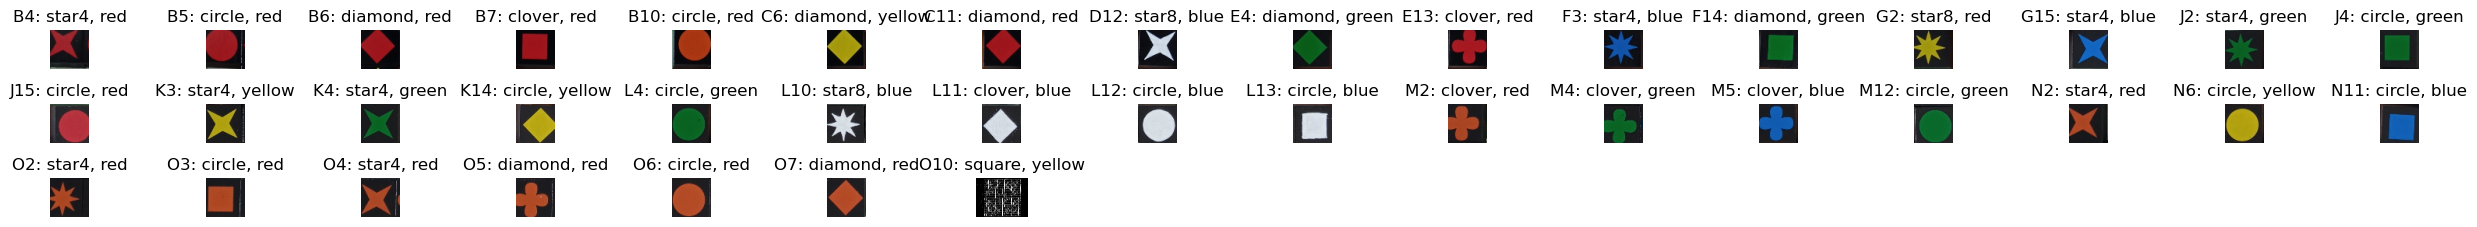

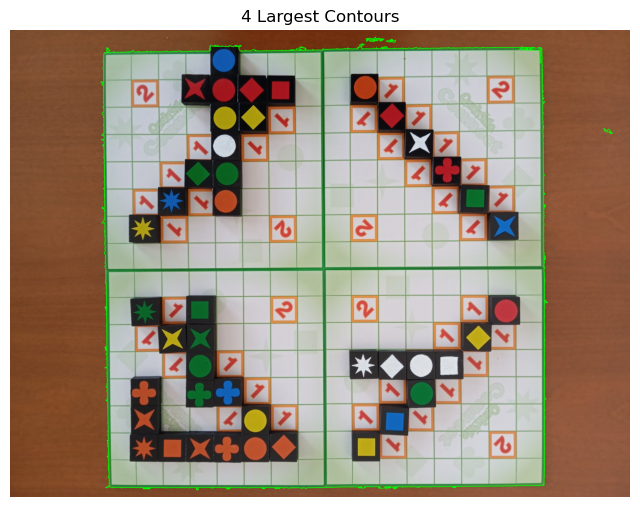

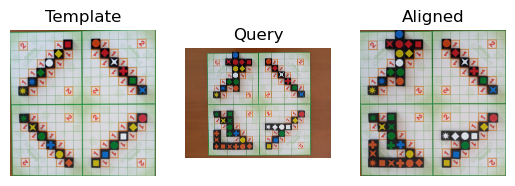

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at A5: circle
Tile at B4: star4
Tile at B5: circle
Tile at B6: diamond
Tile at B7: circle
Tile at B10: circle
Tile at C5: circle
Tile at C6: diamond
Tile at C11: diamond
Tile at D5: 0
Tile at D12: star4
Tile at E4: clover
Tile at E5: circle
Tile at E13: clover
Tile at F3: star4
Tile at F5: circle
Tile at F14: circle
Tile at G2: clover
Tile at G15: clover
Tile at J2: clover
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: star4
Tile at K14: circle
Tile at L4: circle
Tile at L10: star4
Tile at L11: clover
Tile at L12: circle
Tile at L13: circle
Tile at M2: clover
Tile at M4: clover
Tile at M5: clover
Tile at M12: circle
Tile at N2: star4
Tile at N6: circle
Tile at N11: circle
Tile at O2: star4
Tile at O3: circle
Tile at O4: star4
Tile at O5: circle
Tile at O6: circle
Tile at O7: circle
Tile at O10: circle


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

A5: blue
B4: red
B5: red
B6: red
B7: red
B10: red
C5: yellow
C6: red
C11: red
D12: red
E4: green
E5: green
E13: red
F3: blue
F5: red
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: red
K4: green
K14: red
L4: green
L10: green
L11: green
L12: red
L13: red
M2: red
M4: green
M5: blue
M12: green
N2: red
N6: red
N11: blue
O2: red
O3: red
O4: red
O5: red
O6: red
O7: red
O10: red
Move 6: A5: circleblue
B4: star4red
B5: circlered
B6: diamondred
B7: circlered
B10: circlered
C5: circleyellow
C6: diamondred
C11: diamondred
D12: star4red
E4: clovergreen
E5: circlegreen
E13: cloverred
F3: star4blue
F5: circlered
F14: circlegreen
G2: cloverred
G15: cloverblue
J2: clovergreen
J4: circlegreen
J15: circlered
K3: star4red
K4: star4green
K14: circlered
L4: circlegreen
L10: star4green
L11: clovergreen
L12: circlered
L13: circlered
M2: cloverred
M4: clovergreen
M5: cloverblue
M12: circlegreen
N2: star4red
N6: circlered
N11: circleblue
O2: star4red
O3: circlered
O4: star4red
O5: circlered
O6: c

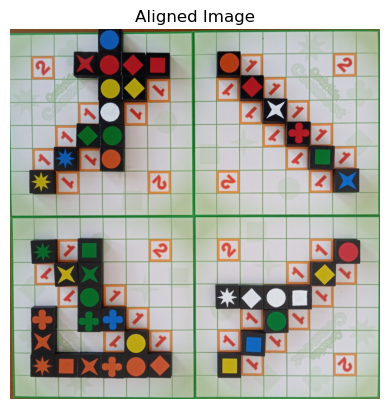

<Figure size 2000x1200 with 0 Axes>

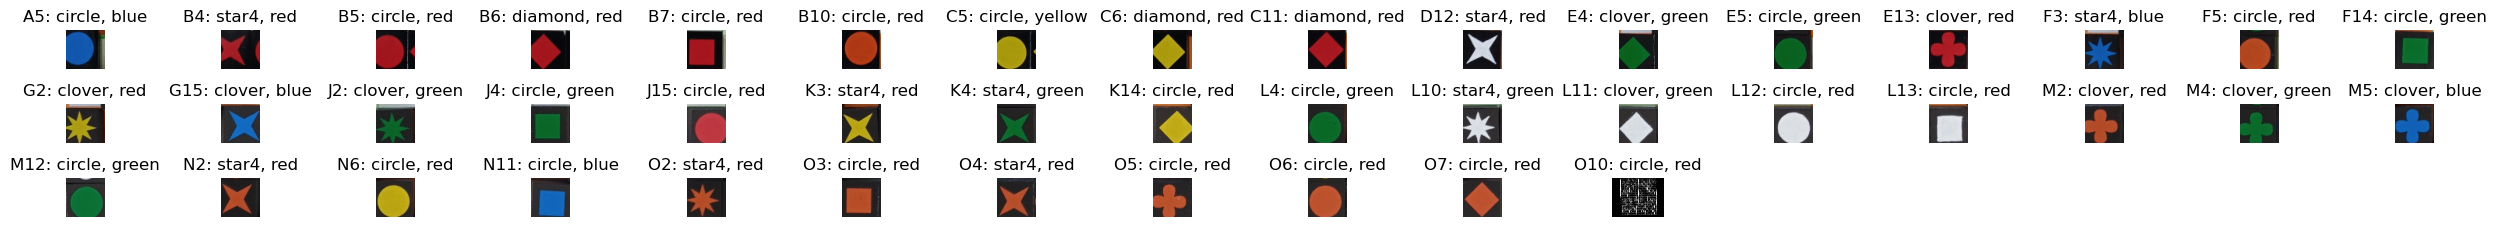

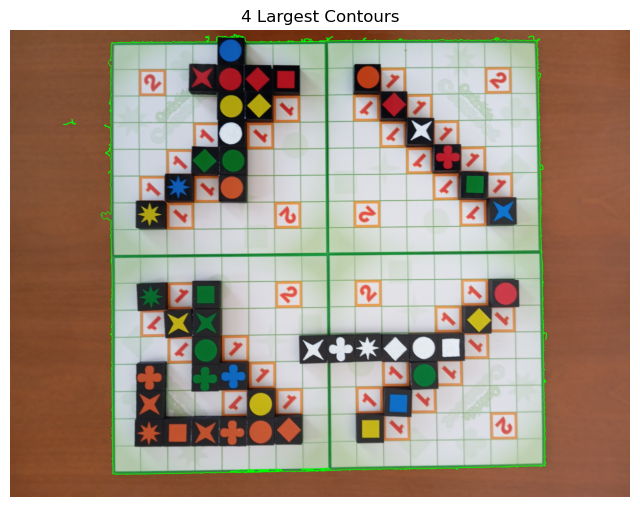

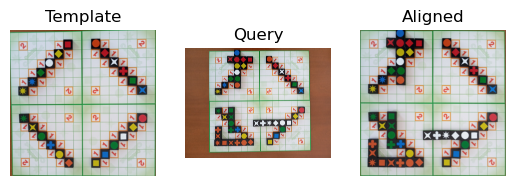

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at A5: circle
Tile at B4: star4
Tile at B5: circle
Tile at B6: diamond
Tile at B7: square
Tile at B10: circle
Tile at C5: circle
Tile at C6: circle
Tile at C11: diamond
Tile at D5: circle
Tile at D12: star4
Tile at E4: diamond
Tile at E5: circle
Tile at E13: clover
Tile at F3: star4
Tile at F5: circle
Tile at F14: square
Tile at G2: star4
Tile at G15: circle
Tile at J2: clover
Tile at J4: circle
Tile at J15: circle
Tile at K3: star4
Tile at K4: clover
Tile at K14: circle
Tile at L4: circle
Tile at L8: clover
Tile at L9: clover
Tile at L10: clover
Tile at L11: circle
Tile at L12: circle
Tile at L13: circle
Tile at M2: clover
Tile at M4: circle
Tile at M5: circle
Tile at M12: circle
Tile at N2: star4
Tile at N6: circle
Tile at N11: circle
Tile at O2: star4
Tile at O3: circle
Tile at O4: star4
Tile at O5: circle
Tile at O6: circle
Tile at O7: circle
Tile at O10: circle


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

A5: blue
B4: red
B5: red
B6: red
B7: red
B10: red
C5: yellow
C6: orange
C11: red
D5: blue
D12: red
E4: green
E5: green
E13: red
F3: blue
F5: red
F14: green
G2: red
G15: blue
J2: green
J4: green
J15: red
K3: red
K4: green
K14: yellow
L4: green
L8: green
L9: empty
L10: empty
L11: empty
L12: red
L13: red
M2: red
M4: green
M5: blue
M12: green
N2: red
N6: yellow
N11: blue
O2: red
O3: red
O4: red
O5: red
O6: red
O7: red
O10: yellow


ValueError: 'empty' is not a valid Color

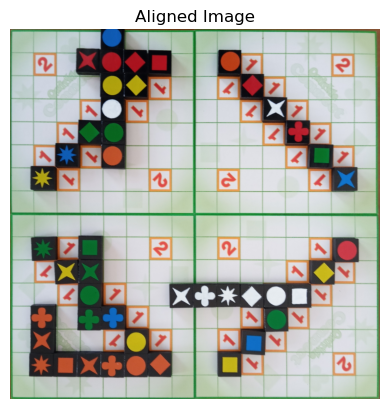

<Figure size 2000x1200 with 0 Axes>

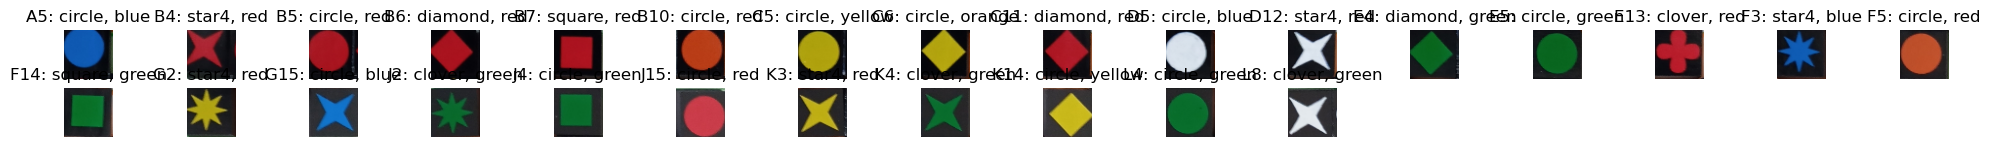

In [ ]:
import re

train_01_list = [f"train/1_{i:02d}.jpg" for i in range(21)] 
input_img = 'evaluation/fake_test/1_02.jpg'
template_img = ["train/1_00.jpg", "train/2_00.jpg", "train/3_00.jpg", "train/4_00.jpg", "train/5_00.jpg"]  
fake_test_template = "evaluation/fake_test/1_00.jpg" 
query_img = input_img        

game = Game()
board = game.board
grid = board.grid
moves = game.moves

already_played_moves = {
    "positions": [],
    "tiles": []
}

move_count = 0
for img in train_01_list:
    match = re.search(r'/(?P<number>\d+)_', img) # THIS MIGHT HAVE TO BE REMOVED WHEN PROJECT FINISHED AND SENT FOR EVALUATION}
    img_num = 0
    if match:
        img_num = match.group('number')
        #set to int
        img_num = int(img_num)
    
    print(f"Processing image: {img}")
    
    warped_img = warp_template(template_img[img_num-1])
    # plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    # plt.axis("off")
    
    aligned_img = align_board(warped_img, img, output_size=(800, 800), show_details=False , use_sift=True, homography_threshold=0.85)
    plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Aligned Image")
    
    detection_grid, cells_grid = split_board(aligned_img    , padding_cell=0, padding_detection=-0.15)
    
    tiles, tiles_present = tile_detection(cells_grid, detection_grid, tile_vs_back_threshol=60, min_foreground_ratio=0.28)
    # Plot tiles with presence detection
    plt.figure(figsize=(20, 12))
    for i, tile in enumerate(tiles, 1):
        label = tile['label']
        tile_present = tile['isPresent']
        plt.subplot(16, 16, i)
        plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
        plt.title(f"{label}: {'Tile' if tile_present else 'No Tile'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Classify tiles and plot classified shapes
    tiles_classified = classify_tiles(tiles_present)
    # plt.figure(figsize=(20, 12))
    # for i, tile in enumerate(tiles_classified, 1):
    #     label = tile['label']
    #     shape = tile['shape']
    #     plt.subplot(16, 16, i)
    #     plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    #     plt.title(f"{label}: {shape}")
    #     plt.axis("off")
    # plt.tight_layout()
    # plt.show()
    
    # Update tiles_present list with the classified shapes (remove shapes that are 0, 7, 8, 9)
    
    #plot tiles 0, 7, 8, 9
    plt.figure(figsize=(20, 12))
    for i, tile in enumerate(tiles_present, 1):
        if tile['label'] not in ["0", "7", "8", "9"]:
            continue
        label = tile['label']
        shape = tile['shape']
        plt.subplot(16, 16, i)
        plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
        plt.title(f"{label}: {shape}")
        plt.axis("off")
    plt.tight_layout()
    
    tiles_present = [
        {**tile, 'shape': next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None)}
        for tile in tiles_present
        if next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None) not in ["0", "7", "8", "9"]
    ]
    
    tiles_full_classified = classify_tiles_full(tiles_present, tiles_classified)
    # Plot patches with tiles with both shape and color
    plt.figure(figsize=(25, 12))
    
    new_positions = {
        "positions": [],
        "tiles": []
    }
    
    for i, tile in enumerate(tiles_full_classified, 1):

        if tile['label'] not in already_played_moves:
            already_played_moves['positions'].append(tile['label'])
            already_played_moves['tiles'].append(Tile(Shape(tile['shape']), Color(tile['color'])))
            new_positions['positions'].append(tile['label'])
            new_positions['tiles'].append(Tile(Shape(tile['shape']), Color(tile['color'])))

        label = tile['label']
        shape = tile['shape']
        color = tile['color']
        plt.subplot(16, 16, i)
        plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
        plt.title(f"{label}: {shape}, {color}")
        plt.axis("off")
    plt.tight_layout()
    
    move = Move(new_positions['positions'], new_positions['tiles'])
    game.apply_move(move)
    print(f"Move {move_count}: {move}")
    
    move_count += 1